# Stratification
Let's start with the **concept of stratification** by giving an example where
we can get into trouble if we are not careful. Let's load the **iris dataset**.

In [1]:
from sklearn.datasets import load_iris

data, target = load_iris(as_frame=True, return_X_y=True)

At this point, we create a basic machine-learning model: a **logistic
regression**. We expect this model to work quite well on the iris dataset since
this is a toy dataset.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())

Once we created our model, we will use the cross-validation framework to
evaluate it. We will use the **`KFold` cross-validation strategy**.
We will define a dataset with **nine samples** and repeat the cross-validation
three times (i.e. `n_splits`).

In [3]:
import numpy as np
from sklearn.model_selection import KFold

data_random = np.random.randn(9, 1)
cv = KFold(n_splits=3)
for train_index, test_index in cv.split(data_random):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [3 4 5 6 7 8] TEST: [0 1 2]
TRAIN: [0 1 2 6 7 8] TEST: [3 4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7 8]


By defining three splits, we will use three samples for testing and six for
training each time. `KFold` does not shuffle by default. It means that it
will select the three first samples for the testing set at the first split,
then the three next three samples for the second split, and the three next
for the last split. In the end, all samples have been used in testing at
least once among the different splits.

Now, let's apply this strategy to check the statistical performance of our
model.

In [4]:
from sklearn.model_selection import cross_validate

cv = KFold(n_splits=3)
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The average accuracy is 0.000 +/- 0.000


It is a **real surprise** that our model cannot correctly classify any sample in
any cross-validation split. We will now check our target's value to
understand the issue.

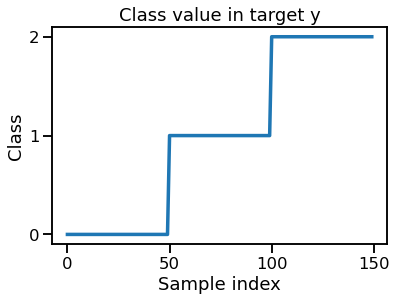

In [5]:
import matplotlib.pyplot as plt

target.plot()
plt.xlabel("Sample index")
plt.ylabel("Class")
plt.yticks(target.unique())
_ = plt.title("Class value in target y")

We see that the **target vector `target` is ordered**. It will have some
unexpected consequences when using the `KFold` cross-validation. To
illustrate the consequences, we will show the class count in each fold of the
cross-validation in the train and test set.

Let's compute the class counts for both the training and test sets using
the `KFold` cross-validation, and plot these information in a bar plot.

We iterate given the number of split and check how many samples of each
are present in the training and testing set. We will store the information
into two distincts lists; one for the training set and one for the test
set.

In [6]:
import pandas as pd

n_splits = 3
cv = KFold(n_splits=n_splits)

train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())

To plot the information on a single figure, we will concatenate the
information regarding the fold within the same dataset.

In [7]:
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Fold #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Class label"
train_cv_counts

,Fold #0,Fold #1,Fold #2
Class label,,,
0,NaN,50.0,50.0
1,50.0,NaN,50.0
2,50.0,50.0,NaN


In [8]:
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Fold #{idx}" for idx in range(n_splits)])
test_cv_counts.index.name = "Class label"
test_cv_counts

,Fold #0,Fold #1,Fold #2
Class label,,,
0,50.0,NaN,NaN
1,NaN,50.0,NaN
2,NaN,NaN,50.0


Now we can represent graphically this information with bar plots.

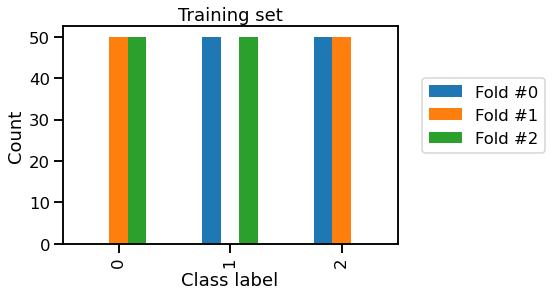

In [9]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set")

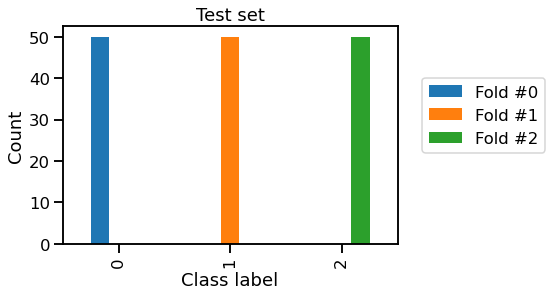

In [10]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set")

We can confirm that in each fold, only two of the three classes are present
in the training set and all samples of the remaining class is used as a test
set. So our model is unable to predict this class that was unseen during the
training stage.

One possibility to solve the issue is to **shuffle the data before splitting**
the data into three groups.

In [11]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The average accuracy is 0.953 +/- 0.009


We get results that are closer to what we expect, with an accuracy above
90%. Now that we solved our first issue, it would be interesting to check if
the class frequency in the training and test set is equal to our original
set's class frequency. It would ensure that we are training and testing our
model with a class distribution that we will encounter in production.

In [12]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Fold #{idx}" for idx in range(n_splits)])
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Fold #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Class label"
test_cv_counts.index.name = "Class label"

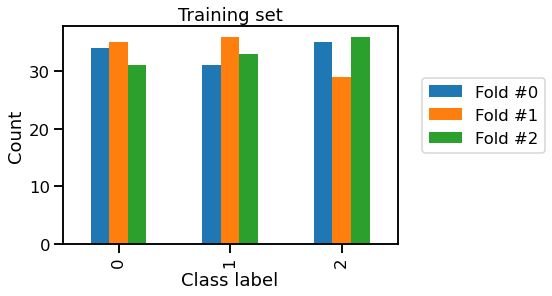

In [13]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set")

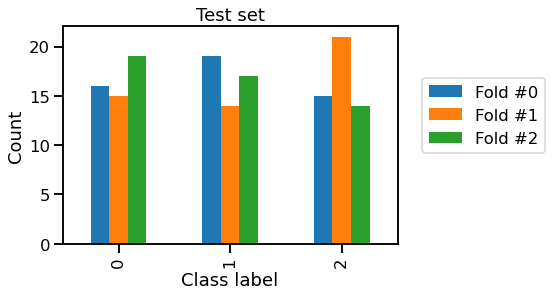

In [14]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set")

We see that neither the training nor test set have the same class
frequencies as our original dataset because the count for each class is
varying a little.

However, one might **want to split our data by preserving the original class
frequencies**: we want to **stratify** our data by class. In **scikit-learn**, some
cross-validation strategies implement the stratification; they contain
**`Stratified` in their names**.

In [15]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3)

In [16]:
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The average accuracy is 0.960 +/- 0.016


In [17]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Fold #{idx}" for idx in range(n_splits)])
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Fold #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Class label"
test_cv_counts.index.name = "Class label"

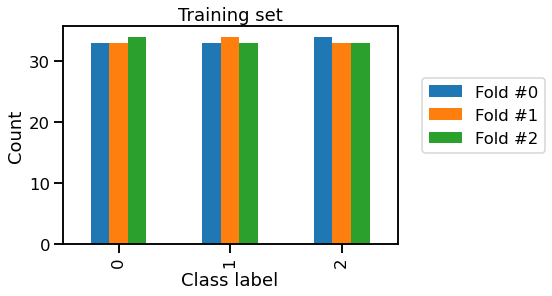

In [18]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set")

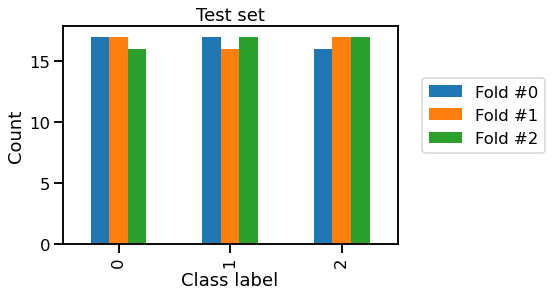

In [19]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set")

In this case, we observe that the class counts are very close both in the
training set and the test set. The difference is due to the small number of
samples in the iris dataset.

In conclusion, it is **good practice** to **use stratification** within the
**cross-validation** framework when dealing with a **classification problem**.